In [2]:
import xarray as xr

In [3]:
# Abrir dataset zarr (lectura rápida, sin cargar todo en memoria)
ds_zarr = xr.open_zarr("/home/aninotna/magister/tesis/justh2_pipeline/data/solar/solar_diario_grilla.zarr")

print(ds_zarr)

# Variables disponibles
print("Variables:", list(ds_zarr.data_vars))

# Coordenadas
print("Coords:", list(ds_zarr.coords))

# Dimensiones y rango de fechas si hay 'time'
if "time" in ds_zarr.coords:
    print("time:", str(ds_zarr.time.values[0]), "→", str(ds_zarr.time.values[-1]))


<xarray.Dataset> Size: 76MB
Dimensions:  (date: 4748, lat: 20, lon: 20)
Coordinates:
  * date     (date) datetime64[ns] 38kB 2004-01-01 2004-01-02 ... 2016-12-30
  * lat      (lat) float64 160B -33.23 -33.17 -33.12 ... -32.38 -32.33 -32.27
  * lon      (lon) float64 160B -71.88 -71.83 -71.72 ... -70.22 -70.12 -70.03
Data variables:
    cloud    (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
    temp     (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
    vel      (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
    dni      (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
    ghi      (date, lat, lon) float64 15MB dask.array<chunksize=(1187, 5, 10), meta=np.ndarray>
Variables: ['cloud', 'temp', 'vel', 'dni', 'ghi']
Coords: ['lat', 'lon', 'date']


In [4]:
# Atributos del dataset y de cada variable
print("Attrs DS:", ds_zarr.attrs)
for v in ds_zarr.data_vars:
    print(f"\n[{v}] attrs:", ds_zarr[v].attrs)

# Chunking por dimensión (útil para performance)
print("\nChunks por dimensión:", ds_zarr.chunks)

# Dtype por variable
for v in ds_zarr.data_vars:
    print(f"{v}: dtype={ds_zarr[v].dtype}")


Attrs DS: {}

[cloud] attrs: {}

[temp] attrs: {}

[vel] attrs: {}

[dni] attrs: {}

[ghi] attrs: {}

Chunks por dimensión: Frozen({'date': (1187, 1187, 1187, 1187), 'lat': (5, 5, 5, 5), 'lon': (10, 10)})
cloud: dtype=float64
temp: dtype=float64
vel: dtype=float64
dni: dtype=float64
ghi: dtype=float64


In [5]:
import numpy as np

lat = ds_zarr.lat.values
lon = ds_zarr.lon.values

print("Lat min/max:", float(lat.min()), float(lat.max()), "n=", lat.size)
print("Lon min/max:", float(lon.min()), float(lon.max()), "n=", lon.size)

# Paso medio (°) de la rejilla
dlat = np.diff(lat).mean()
dlon = np.diff(lon).mean()
print("Δlat medio (°):", float(dlat))
print("Δlon medio (°):", float(dlon))


Lat min/max: -33.225 -32.275 n= 20
Lon min/max: -71.875 -70.025 n= 20
Δlat medio (°): 0.05000000000000015
Δlon medio (°): 0.09736842105263128


In [6]:
import pandas as pd, xarray as xr

ti = pd.DatetimeIndex(ds_zarr.date.values)
print("Fechas: ", ti[0], "→", ti[-1], "n=", len(ti))

# ¿Es diaria y sin huecos?
freq = xr.infer_freq(ti)
print("Frecuencia inferida:", freq)

# Detección de duplicados y gaps
dups = ti.duplicated().sum()
gaps = (ti[1:] - ti[:-1]).value_counts().sort_index()
print("Duplicados en 'date':", int(dups))
print("Saltos de tiempo (conteo por delta):")
print(gaps.head(5))


Fechas:  2004-01-01 00:00:00 → 2016-12-30 00:00:00 n= 4748
Frecuencia inferida: D
Duplicados en 'date': 0
Saltos de tiempo (conteo por delta):
1 days    4747
Name: count, dtype: int64


In [7]:
# Submuestreo ligero para no cargar todo (cada 4 celdas)
sample = ds_zarr.isel(lat=slice(0, None, 4), lon=slice(0, None, 4))

for v in ds_zarr.data_vars:
    nan_ratio = sample[v].isnull().mean().compute().item()
    print(f"{v}: %NaN aprox (submuestra) = {nan_ratio*100:.2f}%")


cloud: %NaN aprox (submuestra) = 20.07%
temp: %NaN aprox (submuestra) = 20.00%
vel: %NaN aprox (submuestra) = 20.00%
dni: %NaN aprox (submuestra) = 20.07%
ghi: %NaN aprox (submuestra) = 20.07%


In [8]:
# Cuantiles sobre submuestra (evita cargar todo)
qs = [0.0, 0.01, 0.5, 0.99, 1.0]
for v in ["dni","ghi","temp","vel","cloud"]:
    q = sample[v].quantile(qs).compute()
    print(f"\n{v} cuantiles {qs}:")
    for p,val in zip(qs, q.values):
        print(f" q{int(p*100):>2}: {val:.3f}")



dni cuantiles [0.0, 0.01, 0.5, 0.99, 1.0]:
 q 0: 1.119
 q 1: 2.699
 q50: 316.418
 q99: 566.332
 q100: 598.805

ghi cuantiles [0.0, 0.01, 0.5, 0.99, 1.0]:
 q 0: 11.224
 q 1: 19.285
 q50: 218.948
 q99: 418.091
 q100: 441.493

temp cuantiles [0.0, 0.01, 0.5, 0.99, 1.0]:
 q 0: -15.947
 q 1: -12.400
 q50: 12.399
 q99: 22.110
 q100: 25.756

vel cuantiles [0.0, 0.01, 0.5, 0.99, 1.0]:
 q 0: 0.463
 q 1: 1.056
 q50: 2.685
 q99: 10.246
 q100: 20.432

cloud cuantiles [0.0, 0.01, 0.5, 0.99, 1.0]:
 q 0: 0.000
 q 1: 0.000
 q50: 0.083
 q99: 0.542
 q100: 0.583


In [8]:
# Recorte espacial por caja
box = ds_zarr.sel(
    lat=slice(-33.1, -32.5),
    lon=slice(-71.5, -70.5)
)
print("Box dims:", {d: box.dims[d] for d in box.dims})

# Serie temporal en el punto más cercano a (lat, lon)
pt = ds_zarr.sel(lat=-33.0, lon=-71.3, method="nearest")

# Estadísticas rápidas en el punto
for v in ["dni","ghi","temp","vel","cloud"]:
    s = pt[v].to_pandas()
    print(f"{v} @({float(pt.lat):.3f},{float(pt.lon):.3f}) min/mean/max:",
          float(s.min()), float(s.mean()), float(s.max()))

# Medias mensuales (punto)
ghi_mon = pt["ghi"].resample(date="MS").mean().to_pandas()
print("GHI mensual (primeros 6):")
print(ghi_mon.head(6))


Box dims: {'date': 4748, 'lat': 12, 'lon': 10}
dni @(-32.975,-71.325) min/mean/max: 2.9599999999999995 294.6673079152614 575.3304166666667
ghi @(-32.975,-71.325) min/mean/max: 12.786666666666667 219.00101847948287 415.4766666666667
temp @(-32.975,-71.325) min/mean/max: 6.367916666666667 14.649597725358047 26.234166666666667
vel @(-32.975,-71.325) min/mean/max: 0.37166666666666665 1.777822591968548 4.925
cloud @(-32.975,-71.325) min/mean/max: 0.0 0.16433916526138279 0.5416666666666666
GHI mensual (primeros 6):
date
2004-01-01    351.210618
2004-02-01    307.032356
2004-03-01    233.319677
2004-04-01    167.246583
2004-05-01    109.666290
2004-06-01     95.424694
Freq: MS, Name: ghi, dtype: float64


/tmp/ipykernel_275466/1555637727.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Box dims:", {d: box.dims[d] for d in box.dims})


In [9]:
# Promedio espacial → serie temporal
ghi_ts = ds_zarr["ghi"].mean(dim=("lat","lon"))
# Climatología mensual (2004-2016)
ghi_clim = ghi_ts.groupby("date.month").mean("date").compute()
print("Climatología GHI mensual (W/m²) [1..12]:")
print(ghi_clim.values)


Climatología GHI mensual (W/m²) [1..12]:
[357.12668862 319.88605535 258.77362668 177.61921078 111.97370266
  89.20496517  95.17603839 129.813231   190.37895152 257.32117235
 325.69399272 366.12011438]


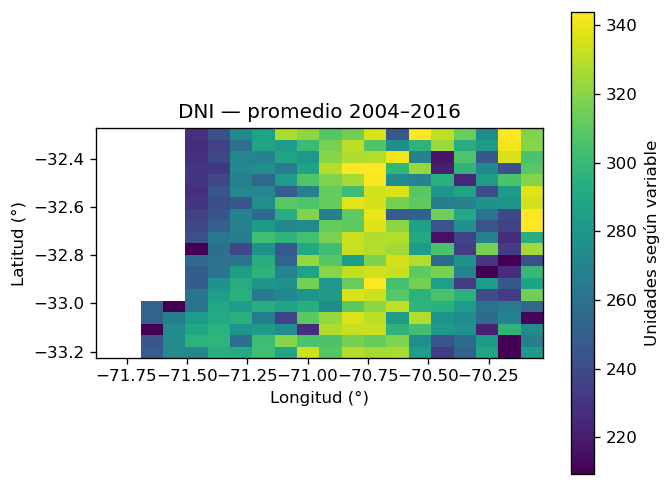

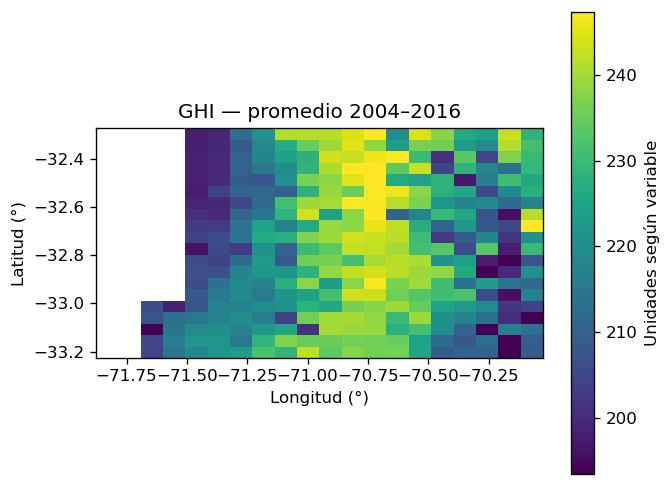

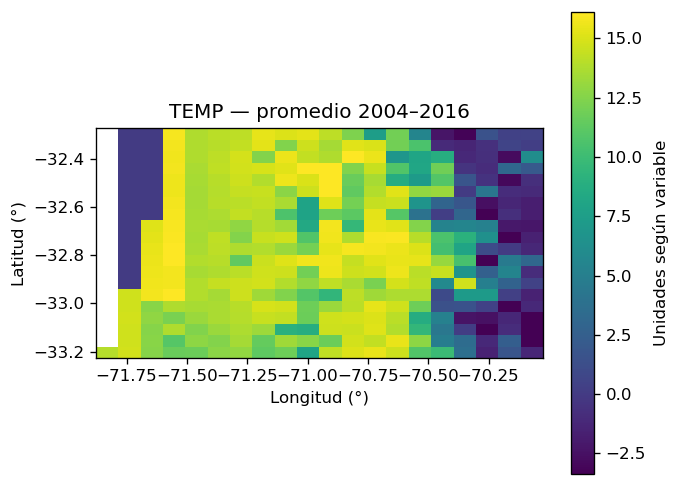

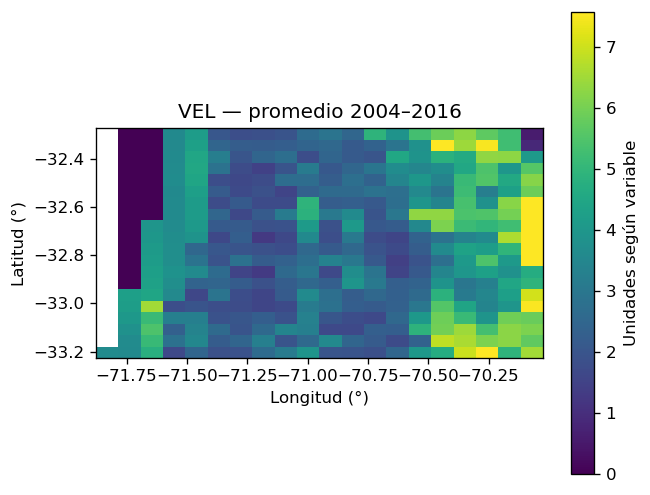

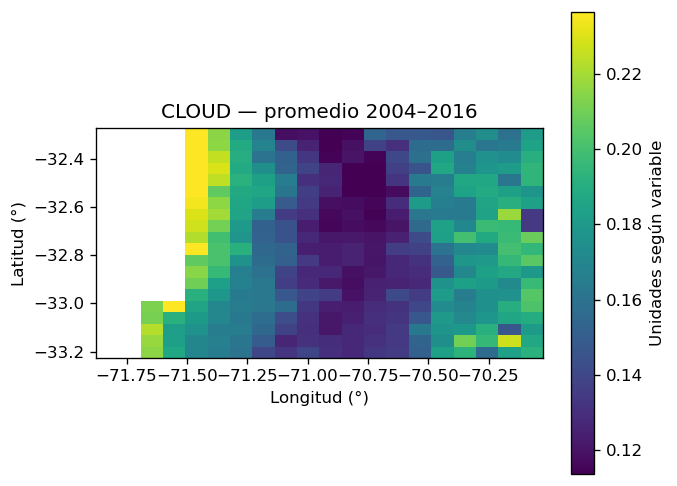

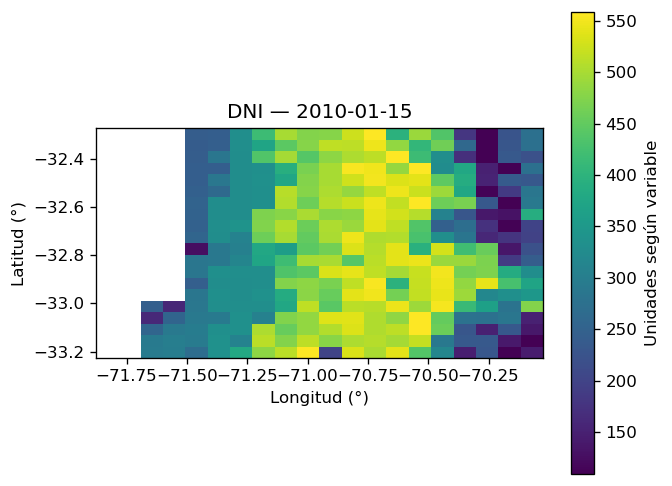

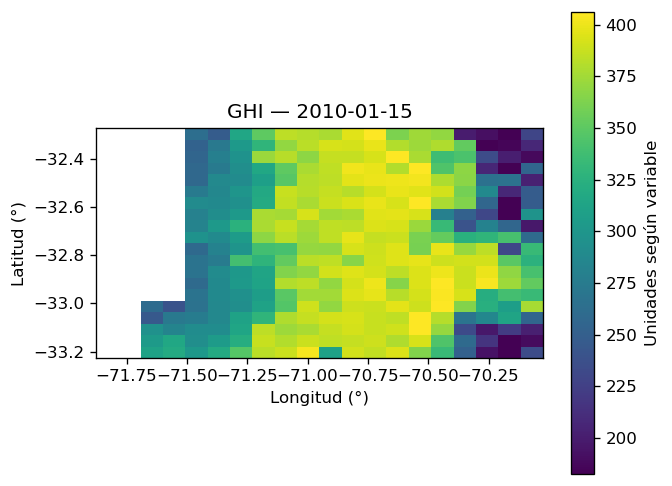

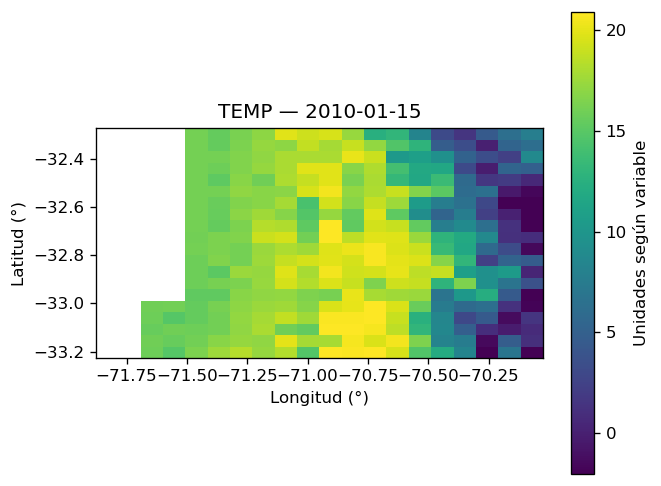

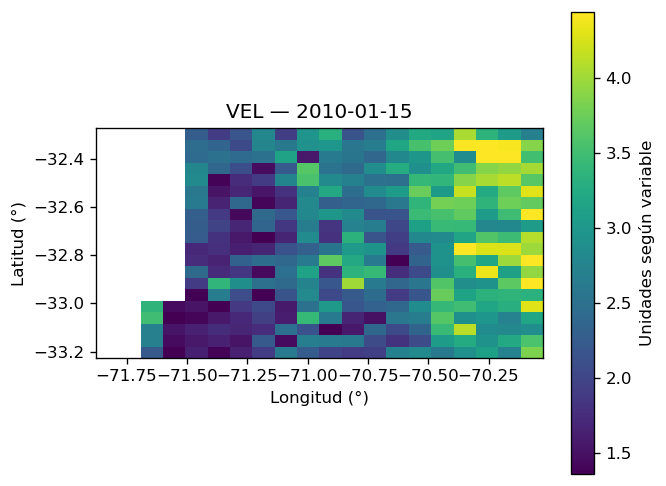

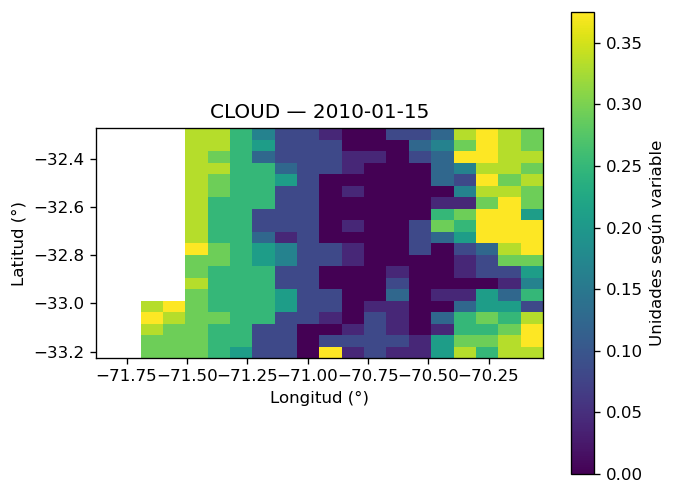

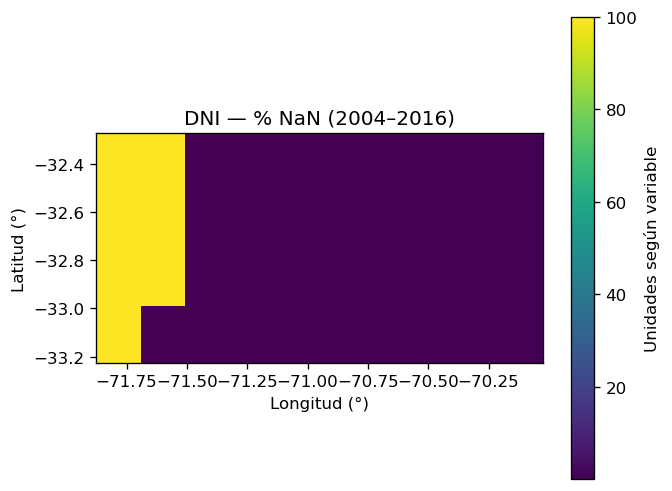

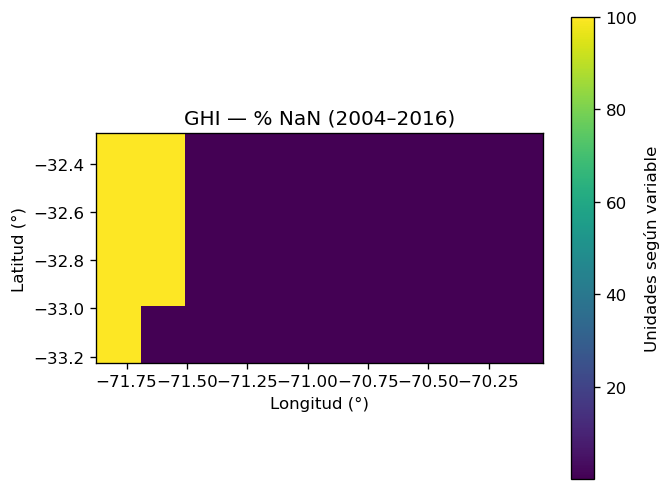

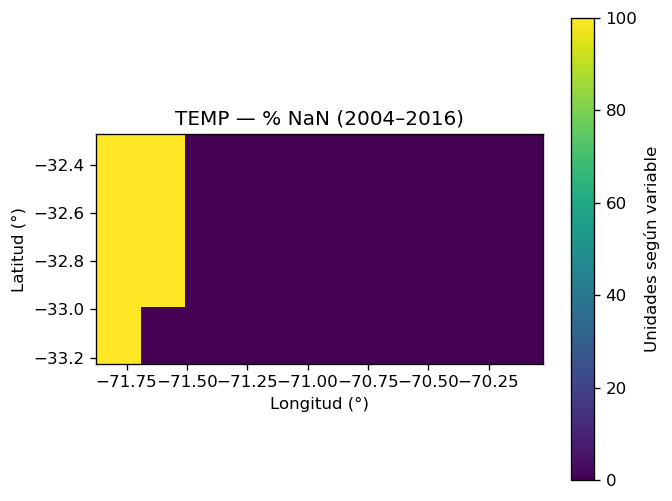

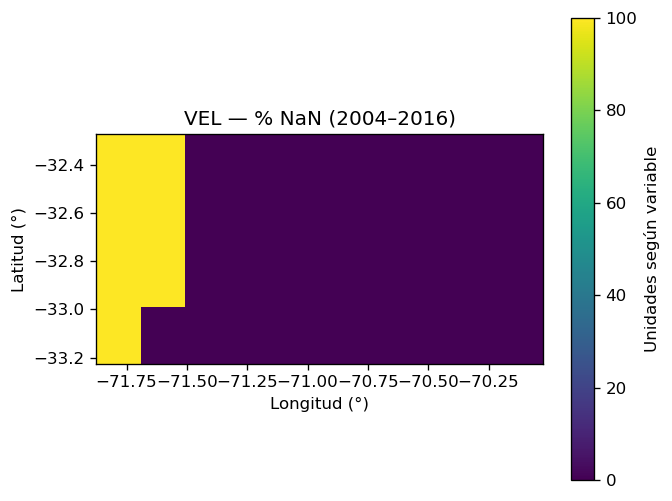

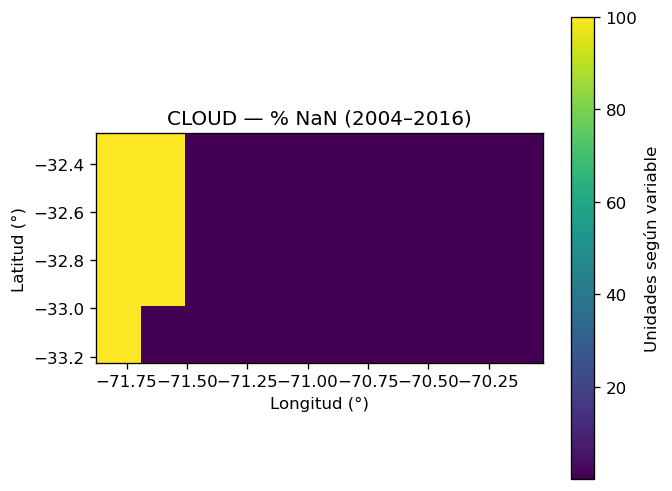

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- Utilidad para mapear 2D lat-lon ---
def plot_map_2d(arr2d, lon, lat, title="", fname=None, qmin=0.02, qmax=0.98):
    """Dibuja un mapa lat-lon con imshow y límites robustos (cuantiles)."""
    data = np.asarray(arr2d)
    # Manejo robusto del rango de color
    finite = np.isfinite(data)
    vmin = np.nanquantile(data[finite], qmin) if finite.any() else np.nan
    vmax = np.nanquantile(data[finite], qmax) if finite.any() else np.nan

    fig, ax = plt.subplots(figsize=(6,5), dpi=120)
    im = ax.imshow(
        data,
        origin="lower",  # lat crece hacia arriba
        extent=[float(ds_zarr.lon.min()), float(ds_zarr.lon.max()),
                float(ds_zarr.lat.min()), float(ds_zarr.lat.max())],
        vmin=vmin, vmax=vmax, interpolation="nearest", aspect="equal"
    )
    ax.set_title(title)
    ax.set_xlabel("Longitud (°)")
    ax.set_ylabel("Latitud (°)")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Unidades según variable")
    if fname:
        plt.savefig(fname, bbox_inches="tight")
    plt.show()

# --- 1) MAPAS DEL PROMEDIO ESPACIAL (PROMEDIO EN EL TIEMPO) ---
vars_to_plot = ["dni", "ghi", "temp", "vel", "cloud"]  # orden sugerido
mean_maps = ds_zarr[vars_to_plot].mean(dim="date").compute()

for v in vars_to_plot:
    plot_map_2d(
        mean_maps[v].values,
        ds_zarr.lon.values, ds_zarr.lat.values,
        title=f"{v.upper()} — promedio 2004–2016",
        fname=f"map_{v}_mean.png"
    )

# --- 2) MAPA EN UNA FECHA ESPECÍFICA (instantáneo) ---
# Cambia esta fecha a la que quieras dentro del rango disponible
date_sel = "2010-01-15"
snap = ds_zarr.sel(date=date_sel)[vars_to_plot].compute()
for v in vars_to_plot:
    plot_map_2d(
        snap[v].values,
        ds_zarr.lon.values, ds_zarr.lat.values,
        title=f"{v.upper()} — {date_sel}",
        fname=f"map_{v}_{date_sel}.png"
    )

# --- 3) (Opcional) % NaN por celda (útil para QA) ---
for v in vars_to_plot:
    nan_frac = ds_zarr[v].isnull().mean(dim="date").compute().values * 100.0
    plot_map_2d(
        nan_frac,
        ds_zarr.lon.values, ds_zarr.lat.values,
        title=f"{v.upper()} — % NaN (2004–2016)",
        fname=f"map_{v}_nanpct.png"
    )
